In [8]:
import numpy as np
import pandas as pd
#from __future__ import division


from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.ensemble import GradientBoostingClassifier

In [9]:
X = pd.read_csv('train_features.csv', sep=",")
X.head(10)

X.info()
X=X.drop(['match_id_hash'],axis=1)
X.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39675 entries, 0 to 39674
Columns: 246 entries, match_id_hash to d5_sen_placed
dtypes: float64(30), int64(215), object(1)
memory usage: 74.5+ MB


,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,...,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
0,155,22,7,1,11,11,0,0,0,0,543,7,533,358,600,350.93784,2,116,122,0.000000,0,0,1,0,0.000000,0,0,0,0,78,0,0,0,3,399,4,478,636,720,254.93774,...,760,760,326.93780,2,90,150,0.000000,0,0,2,1,1.000000,0,0,1,0,34,0,0,0,0,851,11,870,593,680,566.93805,3,128,128,0.000000,0,0,0,0,0.000000,0,0,0,0
1,658,4,0,3,10,15,7,2,0,7,5257,52,3937,1160,1160,566.93805,8,76,78,0.000000,0,0,0,0,0.437500,0,0,0,0,96,3,1,2,3,3394,19,3897,1352,1380,386.93787,...,567,1160,410.93790,6,124,142,0.000000,0,0,6,0,0.500000,0,0,0,0,92,0,2,0,1,1423,8,1136,800,800,446.93793,4,180,176,0.000000,0,0,0,0,0.000000,0,0,0,0
2,21,23,0,0,0,101,0,0,0,0,176,0,0,680,680,506.93800,1,118,118,0.000000,0,0,0,0,0.000000,0,0,0,0,51,0,0,0,0,176,0,0,720,720,278.93777,...,600,600,302.93777,1,176,110,0.000000,0,0,0,0,0.000000,0,0,0,0,17,0,0,0,0,96,0,0,640,640,446.93793,1,162,162,0.000000,0,0,0,0,0.000000,0,0,0,0
3,576,22,7,1,4,14,1,0,3,1,1613,0,1471,900,900,290.93777,4,170,96,2.366089,0,0,5,0,0.571429,0,0,0,0,99,1,0,1,2,2816,30,3602,878,1100,494.93796,...,1160,1160,386.93787,4,176,100,4.998863,0,0,2,0,0.000000,0,0,0,0,86,0,1,0,1,1333,2,1878,630,740,518.93800,5,82,160,8.664527,3,1,3,0,0.000000,0,0,2,0
4,453,22,7,1,3,42,0,1,1,0,1404,9,1351,1000,1000,338.93784,4,80,164,9.930903,0,0,4,0,0.500000,0,0,0,0,69,1,0,0,0,1840,14,1693,868,1000,350.93784,...,680,680,374.93787,4,176,108,13.596678,0,0,2,0,0.500000,0,0,0,0,1,0,1,1,8,2199,32,1919,692,740,302.93777,5,104,162,0.000000,2,1,2,0,0.250000,0,0,0,0
5,160,22,7,0,0,57,0,0,0,1,403,0,359,740,740,290.93777,2,92,148,0.000000,0,0,1,0,0.000000,0,0,0,0,10,0,0,0,1,541,3,1045,685,720,290.93777,...,491,740,374.93787,2,184,100,0.000000,0,0,0,0,0.000000,0,0,0,0,8,0,0,0,0,417,9,275,218,680,278.93777,2,182,174,0.000000,0,0,0,0,0.000000,0,0,0,0
6,1016,22,0,1,0,119,0,3,3,5,3085,1,2828,495,740,816.93830,6,112,112,21.451569,0,0,18,0,0.300000,0,0,5,2,71,2,5,6,2,2985,6,3231,1140,1140,386.93787,...,1016,1240,542.93800,10,136,154,0.000000,0,0,1,0,0.500000,0,0,0,0,90,0,1,3,8,2761,9,3632,734,800,626.93810,8,92,172,8.264696,0,0,3,0,0.250000,0,0,3,0
7,582,22,7,2,2,12,3,1,2,9,3516,40,3964,495,960,530.93800,8,120,118,0.000000,0,0,2,0,0.833333,0,0,0,0,49,0,6,3,6,1972,18,2238,980,980,350.93784,...,787,800,554.93805,7,176,90,17.395752,0,0,4,0,0.200000,0,0,1,1,68,2,2,3,0,1707,2,754,620,620,434.93793,3,126,126,15.762911,3,1,0,1,0.500000,0,0,3,0
8,636,22,7,1,5,74,1,1,0,3,3041,35,4316,923,940,698.93820,9,114,114,1.299609,3,1,0,0,0.333333,0,0,1,0,14,1,2,2,1,1615,0,1620,940,940,290.93777,...,594,1060,530.93800,9,96,158,1.699567,6,1,4,0,0.285714,0,0,0,0,76,3,1,0,16,4795,72,5671,1143,1200,1336.93870,10,118,122,8.064697,0,0,1,0,0.428571,0,0,1,0
9,1054,22,0,8,5,71,1,3,10,4,3627,12,3715,1400,1400,422.93790,8,154,102,44.455677,0,0,4,0,0.785714,0,0,0,0,84,4,1,4,6,4918,23,5011,1260,1260,744.93823,...,1000,1000,398.93787,10,114,156,20.428410,0,0,1,0,0.818182,0,0,0,0,17,1,2,6,7,6596,79,6475,1000,1000,1118.93860,11,182,176,2.899237,0,0,11,0,0.636364,0,0,0,0


In [10]:
for i in X.columns:
    X[i] = X[i].astype(int)

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39675 entries, 0 to 39674
Columns: 245 entries, game_time to d5_sen_placed
dtypes: int64(245)
memory usage: 74.2 MB


In [12]:
X.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,...,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
0,155,22,7,1,11,11,0,0,0,0,543,7,533,358,600,350,2,116,122,0,0,0,1,0,0,0,0,0,0,78,0,0,0,3,399,4,478,636,720,254,...,760,760,326,2,90,150,0,0,0,2,1,1,0,0,1,0,34,0,0,0,0,851,11,870,593,680,566,3,128,128,0,0,0,0,0,0,0,0,0,0
1,658,4,0,3,10,15,7,2,0,7,5257,52,3937,1160,1160,566,8,76,78,0,0,0,0,0,0,0,0,0,0,96,3,1,2,3,3394,19,3897,1352,1380,386,...,567,1160,410,6,124,142,0,0,0,6,0,0,0,0,0,0,92,0,2,0,1,1423,8,1136,800,800,446,4,180,176,0,0,0,0,0,0,0,0,0,0
2,21,23,0,0,0,101,0,0,0,0,176,0,0,680,680,506,1,118,118,0,0,0,0,0,0,0,0,0,0,51,0,0,0,0,176,0,0,720,720,278,...,600,600,302,1,176,110,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,96,0,0,640,640,446,1,162,162,0,0,0,0,0,0,0,0,0,0
3,576,22,7,1,4,14,1,0,3,1,1613,0,1471,900,900,290,4,170,96,2,0,0,5,0,0,0,0,0,0,99,1,0,1,2,2816,30,3602,878,1100,494,...,1160,1160,386,4,176,100,4,0,0,2,0,0,0,0,0,0,86,0,1,0,1,1333,2,1878,630,740,518,5,82,160,8,3,1,3,0,0,0,0,2,0
4,453,22,7,1,3,42,0,1,1,0,1404,9,1351,1000,1000,338,4,80,164,9,0,0,4,0,0,0,0,0,0,69,1,0,0,0,1840,14,1693,868,1000,350,...,680,680,374,4,176,108,13,0,0,2,0,0,0,0,0,0,1,0,1,1,8,2199,32,1919,692,740,302,5,104,162,0,2,1,2,0,0,0,0,0,0


In [13]:
Y = pd.read_csv('train_targets.csv', sep=",")
Y.head(10)

,match_id_hash,game_time,radiant_win,duration,time_remaining,next_roshan_team
0,a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
1,b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
2,6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
3,46a0ddce8f7ed2a8d9bd5edcbb925682,576,True,1952,1376,NaN
4,b1b35ff97723d9b7ade1c9c3cf48f770,453,False,2001,1548,NaN
5,19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
6,c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
7,156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire
8,df50f738c454d430a33b2bf90cb9ef1a,636,False,2059,1423,NaN
9,7469e9440ea3d19b211a484647c7126e,1054,False,2287,1233,NaN


In [14]:
Y=Y.drop(['match_id_hash'],axis=1)
Y=Y.drop(['game_time'],axis=1)
Y=Y.drop(['duration'],axis=1)
Y=Y.drop(['time_remaining'],axis=1)
Y=Y.drop(['next_roshan_team'],axis=1)

In [15]:
Y["radiant_win"] = Y["radiant_win"].astype(int)

In [98]:
print(len(Y))
print(len(X))

39675
39675


In [10]:
corr = X.corr() # .corr is used to find corelation
f,ax = plt.subplots(figsize=(180, 120))
sns.heatmap(corr, cbar = True,  square = True, annot = False, fmt= '.1f', 
            xticklabels= True, yticklabels= True
            ,cmap="coolwarm", linewidths=.5, ax=ax)
plt.title('CORRELATION MATRIX - HEATMAP', size=30);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


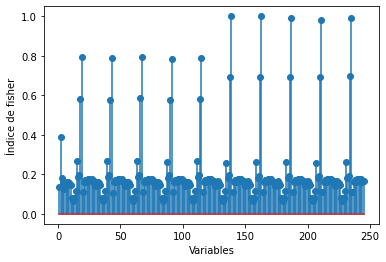

In [11]:
def fisher_index(X, plot=True):
    C = X.shape[1]
    indexes = np.zeros(245)

    j = 0
    for i in range(C):
        if_j = 0
        for k in range(C):
            if i == k:
                continue
            mean_i = np.mean(X[:,i])
            mean_k = np.mean(X[:,k])
            std_i = np.std(X[:,i])
            std_k = np.std(X[:,k])

            if_j += ((mean_i - mean_k)**2 )/(std_i**2 + std_k**2)
        indexes[j] = if_j
        j += 1

    indexes = indexes / np.max(indexes)
  
    if plot == True:
        x = np.array(np.linspace(1, C, C))
        y = indexes
        plt.stem(x, y)
        plt.xlabel('Variables')
        plt.ylabel('Índice de fisher')
        plt.show()    
    return indexes

W=fisher_index(X.values,plot=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


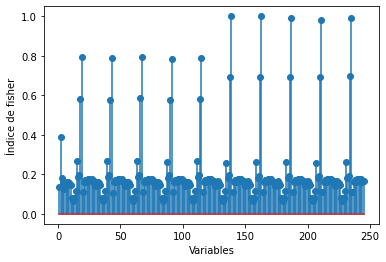

array([0.13464827, 0.38665204, 0.18063714, 0.15564913, 0.12710301,
       0.13908636, 0.15924413, 0.1638229 , 0.15548855, 0.14443348,
       0.08117835, 0.06668144, 0.08200745, 0.11581619, 0.26526475,
       0.18467537, 0.19484727, 0.58050175, 0.79134615, 0.10897111,
       0.16317292, 0.17299227, 0.16098806, 0.1755949 , 0.17644261,
       0.17264585, 0.17670665, 0.16282641, 0.16467983, 0.1416527 ,
       0.15972063, 0.1636937 , 0.15547157, 0.14474168, 0.0825818 ,
       0.06700953, 0.08220835, 0.11706517, 0.26778547, 0.18816628,
       0.19516685, 0.5770624 , 0.78720548, 0.1081949 , 0.16282794,
       0.17298492, 0.1607968 , 0.17559423, 0.17645217, 0.17271154,
       0.17672611, 0.16195338, 0.16397689, 0.1419894 , 0.15956401,
       0.16358845, 0.15555914, 0.14454724, 0.0818109 , 0.06684672,
       0.08236515, 0.11760955, 0.26853125, 0.18667463, 0.19513168,
       0.58448316, 0.79393747, 0.10878552, 0.16178546, 0.17285986,
       0.16111333, 0.17554494, 0.17642832, 0.17264823, 0.17669

In [12]:
fisher_index(X.values, plot=True)


In [25]:
print(W)

[0.13464827 0.38665204 0.18063714 0.15564913 0.12710301 0.13908636
 0.15924413 0.1638229  0.15548855 0.14443348 0.08117835 0.06668144
 0.08200745 0.11581619 0.26526475 0.18467537 0.19484727 0.58050175
 0.79134615 0.10897111 0.16317292 0.17299227 0.16098806 0.1755949
 0.17644261 0.17264585 0.17670665 0.16282641 0.16467983 0.1416527
 0.15972063 0.1636937  0.15547157 0.14474168 0.0825818  0.06700953
 0.08220835 0.11706517 0.26778547 0.18816628 0.19516685 0.5770624
 0.78720548 0.1081949  0.16282794 0.17298492 0.1607968  0.17559423
 0.17645217 0.17271154 0.17672611 0.16195338 0.16397689 0.1419894
 0.15956401 0.16358845 0.15555914 0.14454724 0.0818109  0.06684672
 0.08236515 0.11760955 0.26853125 0.18667463 0.19513168 0.58448316
 0.79393747 0.10878552 0.16178546 0.17285986 0.16111333 0.17554494
 0.17642832 0.17264823 0.1766903  0.16217905 0.16415807 0.14163469
 0.15949552 0.16364245 0.1556942  0.14438582 0.08122855 0.0665113
 0.08189412 0.115992   0.26459715 0.18401419 0.19489623 0.57859703


In [44]:
for i in range(len(W)):
  #print("vi",i)
  if W[i]>0.14:
    print(i+1)

2
3
4
7
8
9
10
15
16
17
18
19
21
22
23
24
25
26
27
28
29
30
31
32
33
34
39
40
41
42
43
45
46
47
48
49
50
51
52
53
54
55
56
57
58
63
64
65
66
67
69
70
71
72
73
74
75
76
77
78
79
80
81
82
87
88
89
90
91
93
94
95
96
97
98
99
100
101
102
103
104
105
106
111
112
113
114
115
117
118
119
120
121
122
123
124
125
126
127
128
129
130
135
136
137
138
139
141
142
143
144
145
146
147
148
149
150
151
152
153
154
159
160
161
162
163
165
166
167
168
169
170
171
172
173
174
175
176
177
178
183
184
185
186
187
189
190
191
192
193
194
195
196
197
198
199
200
201
202
207
208
209
210
211
213
214
215
216
217
218
219
220
221
222
223
224
225
226
231
232
233
234
235
237
238
239
240
241
242
243
244
245


In [17]:
Y = Y['radiant_win'].values
X = X.values
feat_labels = ['game_time','game_mode','lobby_type','objectives_len','chat_len','r1_hero_id','r1_kills','r1_deaths','r1_assists','r1_denies','r1_gold','r1_lh','r1_xp','r1_health','r1_max_health','r1_max_mana','r1_level','r1_x','r1_y','r1_stuns','r1_creeps_stacked','r1_camps_stacked','r1_rune_pickups','r1_firstblood_claimed','r1_teamfight_participation','r1_towers_killed','r1_roshans_killed','r1_obs_placed','r1_sen_placed','r2_hero_id','r2_kills','r2_deaths','r2_assists','r2_denies','r2_gold','r2_lh','r2_xp','r2_health','r2_max_health','r2_max_mana','r2_level','r2_x','r2_y','r2_stuns','r2_creeps_stacked','r2_camps_stacked','r2_rune_pickups','r2_firstblood_claimed','r2_teamfight_participation','r2_towers_killed','r2_roshans_killed','r2_obs_placed','r2_sen_placed','r3_hero_id','r3_kills','r3_deaths','r3_assists','r3_denies','r3_gold','r3_lh','r3_xp','r3_health','r3_max_health','r3_max_mana','r3_level','r3_x','r3_y','r3_stuns','r3_creeps_stacked','r3_camps_stacked','r3_rune_pickups','r3_firstblood_claimed','r3_teamfight_participation','r3_towers_killed','r3_roshans_killed','r3_obs_placed','r3_sen_placed','r4_hero_id','r4_kills','r4_deaths','r4_assists','r4_denies','r4_gold','r4_lh','r4_xp','r4_health','r4_max_health','r4_max_mana','r4_level','r4_x','r4_y','r4_stuns','r4_creeps_stacked','r4_camps_stacked','r4_rune_pickups','r4_firstblood_claimed','r4_teamfight_participation','r4_towers_killed','r4_roshans_killed','r4_obs_placed','r4_sen_placed','r5_hero_id','r5_kills','r5_deaths','r5_assists','r5_denies','r5_gold','r5_lh','r5_xp','r5_health','r5_max_health','r5_max_mana','r5_level','r5_x','r5_y','r5_stuns','r5_creeps_stacked','r5_camps_stacked','r5_rune_pickups','r5_firstblood_claimed','r5_teamfight_participation','r5_towers_killed','r5_roshans_killed','r5_obs_placed','r5_sen_placed','d1_hero_id','d1_kills','d1_deaths','d1_assists','d1_denies','d1_gold','d1_lh','d1_xp','d1_health','d1_max_health','d1_max_mana','d1_level','d1_x','d1_y','d1_stuns','d1_creeps_stacked','d1_camps_stacked','d1_rune_pickups','d1_firstblood_claimed','d1_teamfight_participation','d1_towers_killed','d1_roshans_killed','d1_obs_placed','d1_sen_placed','d2_hero_id','d2_kills','d2_deaths','d2_assists','d2_denies','d2_gold','d2_lh','d2_xp','d2_health','d2_max_health','d2_max_mana','d2_level','d2_x','d2_y','d2_stuns','d2_creeps_stacked','d2_camps_stacked','d2_rune_pickups','d2_firstblood_claimed','d2_teamfight_participation','d2_towers_killed','d2_roshans_killed','d2_obs_placed','d2_sen_placed','d3_hero_id','d3_kills','d3_deaths','d3_assists','d3_denies','d3_gold','d3_lh','d3_xp','d3_health','d3_max_health','d3_max_mana','d3_level','d3_x','d3_y','d3_stuns','d3_creeps_stacked','d3_camps_stacked','d3_rune_pickups','d3_firstblood_claimed','d3_teamfight_participation','d3_towers_killed','d3_roshans_killed','d3_obs_placed','d3_sen_placed','d4_hero_id','d4_kills','d4_deaths','d4_assists','d4_denies','d4_gold','d4_lh','d4_xp','d4_health','d4_max_health','d4_max_mana','d4_level','d4_x','d4_y','d4_stuns','d4_creeps_stacked','d4_camps_stacked','d4_rune_pickups','d4_firstblood_claimed','d4_teamfight_participation','d4_towers_killed','d4_roshans_killed','d4_obs_placed','d4_sen_placed','d5_hero_id','d5_kills','d5_deaths','d5_assists','d5_denies','d5_gold','d5_lh','d5_xp','d5_health','d5_max_health','d5_max_mana','d5_level','d5_x','d5_y','d5_stuns','d5_creeps_stacked','d5_camps_stacked','d5_rune_pickups','d5_firstblood_claimed','d5_teamfight_participation','d5_towers_killed','d5_roshans_killed','d5_obs_placed','d5_sen_placed']

dc = QuadraticDiscriminantAnalysis()

In [ ]:
# Sequential Forward Selection
sfs = SFS(dc, 
          k_features=10, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=4,
          n_jobs=-1)
sfs = sfs.fit(X, Y)

print('\nSequential Forward Selection (k=7):')
print(sfs.k_feature_idx_)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=7):
(7, 8, 18, 65, 66, 103, 175, 185, 186, 199)
CV Score:
0.6658854090587886


In [ ]:
sbfs = SFS(dc, 
           k_features=10, 
           forward=False, 
           floating=True, 
           scoring='accuracy',
           cv=4,
           n_jobs=-1)
sbfs = sbfs.fit(X, Y)


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [ ]:
print('\nSequential Backward Floating Selection (k=7):')
print(sbfs.k_feature_idx_)
print('CV Score:')
print(sbfs.k_score_)


Sequential Backward Floating Selection (k=7):
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 21

In [14]:
feature_names = ('game_time','game_mode','lobby_type','objectives_len','chat_len','r1_hero_id','r1_kills','r1_deaths','r1_assists','r1_denies','r1_gold','r1_lh','r1_xp','r1_health','r1_max_health','r1_max_mana','r1_level','r1_x','r1_y','r1_stuns','r1_creeps_stacked','r1_camps_stacked','r1_rune_pickups','r1_firstblood_claimed','r1_teamfight_participation','r1_towers_killed','r1_roshans_killed','r1_obs_placed','r1_sen_placed','r2_hero_id','r2_kills','r2_deaths','r2_assists','r2_denies','r2_gold','r2_lh','r2_xp','r2_health','r2_max_health','r2_max_mana','r2_level','r2_x','r2_y','r2_stuns','r2_creeps_stacked','r2_camps_stacked','r2_rune_pickups','r2_firstblood_claimed','r2_teamfight_participation','r2_towers_killed','r2_roshans_killed','r2_obs_placed','r2_sen_placed','r3_hero_id','r3_kills','r3_deaths','r3_assists','r3_denies','r3_gold','r3_lh','r3_xp','r3_health','r3_max_health','r3_max_mana','r3_level','r3_x','r3_y','r3_stuns','r3_creeps_stacked','r3_camps_stacked','r3_rune_pickups','r3_firstblood_claimed','r3_teamfight_participation','r3_towers_killed','r3_roshans_killed','r3_obs_placed','r3_sen_placed','r4_hero_id','r4_kills','r4_deaths','r4_assists','r4_denies','r4_gold','r4_lh','r4_xp','r4_health','r4_max_health','r4_max_mana','r4_level','r4_x','r4_y','r4_stuns','r4_creeps_stacked','r4_camps_stacked','r4_rune_pickups','r4_firstblood_claimed','r4_teamfight_participation','r4_towers_killed','r4_roshans_killed','r4_obs_placed','r4_sen_placed','r5_hero_id','r5_kills','r5_deaths','r5_assists','r5_denies','r5_gold','r5_lh','r5_xp','r5_health','r5_max_health','r5_max_mana','r5_level','r5_x','r5_y','r5_stuns','r5_creeps_stacked','r5_camps_stacked','r5_rune_pickups','r5_firstblood_claimed','r5_teamfight_participation','r5_towers_killed','r5_roshans_killed','r5_obs_placed','r5_sen_placed','d1_hero_id','d1_kills','d1_deaths','d1_assists','d1_denies','d1_gold','d1_lh','d1_xp','d1_health','d1_max_health','d1_max_mana','d1_level','d1_x','d1_y','d1_stuns','d1_creeps_stacked','d1_camps_stacked','d1_rune_pickups','d1_firstblood_claimed','d1_teamfight_participation','d1_towers_killed','d1_roshans_killed','d1_obs_placed','d1_sen_placed','d2_hero_id','d2_kills','d2_deaths','d2_assists','d2_denies','d2_gold','d2_lh','d2_xp','d2_health','d2_max_health','d2_max_mana','d2_level','d2_x','d2_y','d2_stuns','d2_creeps_stacked','d2_camps_stacked','d2_rune_pickups','d2_firstblood_claimed','d2_teamfight_participation','d2_towers_killed','d2_roshans_killed','d2_obs_placed','d2_sen_placed','d3_hero_id','d3_kills','d3_deaths','d3_assists','d3_denies','d3_gold','d3_lh','d3_xp','d3_health','d3_max_health','d3_max_mana','d3_level','d3_x','d3_y','d3_stuns','d3_creeps_stacked','d3_camps_stacked','d3_rune_pickups','d3_firstblood_claimed','d3_teamfight_participation','d3_towers_killed','d3_roshans_killed','d3_obs_placed','d3_sen_placed','d4_hero_id','d4_kills','d4_deaths','d4_assists','d4_denies','d4_gold','d4_lh','d4_xp','d4_health','d4_max_health','d4_max_mana','d4_level','d4_x','d4_y','d4_stuns','d4_creeps_stacked','d4_camps_stacked','d4_rune_pickups','d4_firstblood_claimed','d4_teamfight_participation','d4_towers_killed','d4_roshans_killed','d4_obs_placed','d4_sen_placed','d5_hero_id','d5_kills','d5_deaths','d5_assists','d5_denies','d5_gold','d5_lh','d5_xp','d5_health','d5_max_health','d5_max_mana','d5_level','d5_x','d5_y','d5_stuns','d5_creeps_stacked','d5_camps_stacked','d5_rune_pickups','d5_firstblood_claimed','d5_teamfight_participation','d5_towers_killed','d5_roshans_killed','d5_obs_placed','d5_sen_placed')
#sfs1 = sfs1.fit(X, y, custom_feature_names=feature_names)
#sfs1.subsets_

In [34]:
# Sequential Forward Floating Selection
sffs_1 = SFS(dc, 
           k_features=55, 
           forward=True, 
           floating=True, 
           scoring='accuracy',
           cv=4,
           n_jobs=-1)
sffs_1 = sffs_1.fit(X, Y,custom_feature_names=feature_names)
print('\nSequential Forward Floating Selection (k=14):')
print(sffs_1.k_feature_idx_)
print('CV Score:')
print(sffs_1.k_score_)


Sequential Forward Floating Selection (k=14):
(2, 6, 7, 8, 10, 12, 17, 18, 19, 27, 29, 31, 36, 45, 51, 52, 58, 59, 60, 61, 63, 65, 66, 69, 70, 77, 82, 83, 84, 86, 90, 93, 101, 103, 106, 108, 110, 111, 113, 123, 131, 132, 133, 137, 149, 151, 156, 175, 178, 185, 196, 199, 204, 232, 234)
CV Score:
0.6921991299520063


In [13]:
# Sequential Forward Floating Selection
sffs_2 = SFS(dc, 
           k_features=75, 
           forward=True, 
           floating=True, 
           scoring='accuracy',
           cv=4,
           n_jobs=-1)
sffs_2 = sffs_2.fit(X, Y, custom_feature_names=feature_names)

print('\nSequential Forward Floating Selection (k=14):')
print(sffs_2.k_feature_idx_)
print('CV Score:')
print(sffs_2.k_score_)


Sequential Forward Floating Selection (k=14):
(0, 2, 5, 6, 8, 10, 13, 15, 16, 18, 19, 27, 29, 31, 34, 35, 36, 37, 39, 40, 41, 45, 51, 53, 58, 59, 61, 62, 63, 64, 66, 69, 70, 75, 83, 84, 86, 88, 89, 90, 91, 94, 103, 106, 107, 108, 112, 113, 115, 123, 127, 131, 132, 133, 136, 149, 151, 156, 173, 175, 178, 181, 184, 185, 196, 197, 199, 204, 205, 208, 210, 226, 232, 234, 235)
CV Score:
0.7007939013612602


In [ ]:
# Sequential Forward Floating Selection
sffs_3 = SFS(dc, 
           k_features=96, 
           forward=True, 
           floating=True, 
           scoring='accuracy',
           cv=4,
           n_jobs=-1)
sffs_3 = sffs_3.fit(X, Y,custom_feature_names=feature_names)

print('\nSequential Forward Floating Selection (k=21):')
print(sffs_3.k_feature_idx_)
print('CV Score:')
print(sffs_3.k_score_)

In [ ]:
# Sequential Forward Floating Selection
sffs_4 = SFS(dc, 
           k_features=110, 
           forward=True, 
           floating=True, 
           scoring='accuracy',
           cv=4,
           n_jobs=-1)
sffs_4 = sffs_3.fit(X, Y,custom_feature_names=feature_names)

print('\nSequential Forward Floating Selection (k=21):')
print(sffs_4.k_feature_idx_)
print('CV Score:')
print(sffs_4.k_score_)

In [46]:
#Luego de realizar en analisis con la matriz de correlacion y el discriminante de fisher

In [21]:
X_s=X[['game_time','objectives_len','r1_kills','r1_deaths','r1_assists', 'r1_gold','r1_lh','r1_xp' ,'r1_max_health','r1_max_mana','r1_level','r1_stuns','r1_rune_pickups','r1_towers_killed','r2_kills','r2_deaths','r2_assists', 'r2_gold','r2_lh','r2_xp' ,'r2_max_health','r2_max_mana','r2_level','r2_stuns','r2_rune_pickups','r2_towers_killed','r3_kills','r3_deaths','r3_assists', 'r3_gold','r3_lh','r3_xp' ,'r3_max_health','r3_max_mana','r3_level','r3_stuns','r3_rune_pickups','r3_towers_killed','r4_kills','r4_deaths','r4_assists','r4_gold','r4_lh','r4_xp','r4_max_health','r4_max_mana','r4_level','r4_stuns','r4_rune_pickups','r4_towers_killed','r5_kills','r5_deaths','r5_assists', 'r5_gold','r5_lh','r5_xp' ,'r5_max_health','r5_max_mana','r5_level','r5_stuns','r5_rune_pickups','r5_towers_killed','d1_kills','d1_deaths','d1_assists', 'd1_gold','d1_lh','d1_xp' ,'d1_max_health','d1_max_mana','d1_level','d1_stuns','d1_rune_pickups','d1_towers_killed','d2_kills','d2_deaths','d2_assists', 'd2_gold','d2_lh','d2_xp' ,'d2_max_health','d2_max_mana','d2_level','d2_stuns','d2_rune_pickups','d2_towers_killed','d3_kills','d3_deaths','d3_assists', 'd3_gold','d3_lh','d3_xp' ,'d3_max_health','d3_max_mana','d3_level','d3_stuns','d3_rune_pickups','d3_towers_killed','d4_kills','d4_deaths','d4_assists', 'd4_gold','d4_lh','d4_xp' ,'d4_max_health','d4_max_mana','d4_level','d4_stuns','d4_rune_pickups','d4_towers_killed','d5_kills','d5_deaths','d5_assists', 'd5_gold','d5_lh','d5_xp' ,'d5_max_health','d5_max_mana','d5_level','d5_stuns','d5_rune_pickups','d5_towers_killed']].values


In [23]:
X_s=X[['game_time','objectives_len','r1_kills','r1_deaths','r1_assists', 'r1_gold','r1_lh','r1_xp' ,'r1_max_health','r1_max_mana','r1_level','r1_stuns','r1_rune_pickups','r1_towers_killed','r2_kills','r2_deaths','r2_assists', 'r2_gold','r2_lh','r2_xp' ,'r2_max_health','r2_max_mana','r2_level','r2_stuns','r2_rune_pickups','r2_towers_killed','r3_kills','r3_deaths','r3_assists', 'r3_gold','r3_lh','r3_xp' ,'r3_max_health','r3_max_mana','r3_level','r3_stuns','r3_rune_pickups','r3_towers_killed','r4_kills','r4_deaths','r4_assists','r4_gold','r4_lh','r4_xp','r4_max_health','r4_max_mana','r4_level','r4_stuns','r4_rune_pickups','r4_towers_killed','r5_kills','r5_deaths','r5_assists', 'r5_gold','r5_lh','r5_xp' ,'r5_max_health','r5_max_mana','r5_level','r5_stuns','r5_rune_pickups','r5_towers_killed','d1_kills','d1_deaths','d1_assists', 'd1_gold','d1_lh','d1_xp' ,'d1_max_health','d1_max_mana','d1_level','d1_stuns','d1_rune_pickups','d1_towers_killed','d2_kills','d2_deaths','d2_assists', 'd2_gold','d2_lh','d2_xp' ,'d2_max_health','d2_max_mana','d2_level','d2_stuns','d2_rune_pickups','d2_towers_killed','d3_kills','d3_deaths','d3_assists', 'd3_gold','d3_lh','d3_xp' ,'d3_max_health','d3_max_mana','d3_level','d3_stuns','d3_rune_pickups','d3_towers_killed','d4_kills','d4_deaths','d4_assists', 'd4_gold','d4_lh','d4_xp' ,'d4_max_health','d4_max_mana','d4_level','d4_stuns','d4_rune_pickups','d4_towers_killed','d5_kills','d5_deaths','d5_assists', 'd5_gold','d5_lh','d5_xp' ,'d5_max_health','d5_max_mana','d5_level','d5_stuns','d5_rune_pickups','d5_towers_killed']]


In [25]:
X_s.head()

,game_time,objectives_len,r1_kills,r1_deaths,r1_assists,r1_gold,r1_lh,r1_xp,r1_max_health,r1_max_mana,r1_level,r1_stuns,r1_rune_pickups,r1_towers_killed,r2_kills,r2_deaths,r2_assists,r2_gold,r2_lh,r2_xp,r2_max_health,r2_max_mana,r2_level,r2_stuns,r2_rune_pickups,r2_towers_killed,r3_kills,r3_deaths,r3_assists,r3_gold,r3_lh,r3_xp,r3_max_health,r3_max_mana,r3_level,r3_stuns,r3_rune_pickups,r3_towers_killed,r4_kills,r4_deaths,...,d2_level,d2_stuns,d2_rune_pickups,d2_towers_killed,d3_kills,d3_deaths,d3_assists,d3_gold,d3_lh,d3_xp,d3_max_health,d3_max_mana,d3_level,d3_stuns,d3_rune_pickups,d3_towers_killed,d4_kills,d4_deaths,d4_assists,d4_gold,d4_lh,d4_xp,d4_max_health,d4_max_mana,d4_level,d4_stuns,d4_rune_pickups,d4_towers_killed,d5_kills,d5_deaths,d5_assists,d5_gold,d5_lh,d5_xp,d5_max_health,d5_max_mana,d5_level,d5_stuns,d5_rune_pickups,d5_towers_killed
0,155,1,0,0,0,543,7,533,600,350.93784,2,0.000000,1,0,0,0,0,399,4,478,720,254.93774,2,0.000000,0,0,0,1,0,304,0,130,700,242.93773,1,0.000000,1,0,0,0,...,3,0.000000,2,0,0,0,0,531,0,307,720,242.93773,2,0.299948,2,0,1,0,0,796,0,421,760,326.93780,2,0.000000,2,0,0,0,0,851,11,870,680,566.93805,3,0.000000,0,0
1,658,3,7,2,0,5257,52,3937,1160,566.93805,8,0.000000,0,0,3,1,2,3394,19,3897,1380,386.93787,8,8.397949,4,0,1,1,4,2212,4,2561,860,530.93800,6,11.964951,4,0,4,0,...,6,0.066650,1,0,1,3,1,3624,29,3418,800,350.93784,7,0.299955,4,0,0,3,2,2808,18,2730,1160,410.93790,6,0.000000,6,0,0,2,0,1423,8,1136,800,446.93793,4,0.000000,0,0
2,21,0,0,0,0,176,0,0,680,506.93800,1,0.000000,0,0,0,0,0,176,0,0,720,278.93777,1,0.000000,0,0,0,0,0,176,0,0,600,254.93774,1,0.000000,1,0,0,0,...,1,0.000000,0,0,0,0,0,96,0,0,660,290.93777,1,0.000000,1,0,0,0,0,96,0,0,600,302.93777,1,0.000000,0,0,0,0,0,96,0,0,640,446.93793,1,0.000000,0,0
3,576,1,1,0,3,1613,0,1471,900,290.93777,4,2.366089,5,0,1,0,1,2816,30,3602,1100,494.93796,8,0.000000,1,0,3,1,1,4017,44,4811,980,902.93835,9,0.000000,2,0,1,1,...,7,0.000000,1,0,0,1,1,3035,44,2508,860,350.93784,6,0.000000,1,0,0,2,0,2004,16,1644,1160,386.93787,4,4.998863,2,0,0,1,0,1333,2,1878,740,518.93800,5,8.664527,3,0
4,453,1,0,1,1,1404,9,1351,1000,338.93784,4,9.930903,4,0,1,0,0,1840,14,1693,1000,350.93784,5,1.832892,0,0,0,1,0,1204,10,3210,860,792.93823,7,3.499146,0,0,0,0,...,5,2.199399,1,0,0,0,1,2402,35,3544,720,434.93793,7,0.000000,2,0,2,1,0,1697,12,1651,680,374.93787,4,13.596678,2,0,0,1,1,2199,32,1919,740,302.93777,5,0.000000,2,0


In [27]:
for i in X_s.columns:
    X_s[i] = X_s[i].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
X_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39675 entries, 0 to 39674
Columns: 122 entries, game_time to d5_towers_killed
dtypes: int64(122)
memory usage: 36.9 MB


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_important_train,X_important_test,y_important_train, y_important_test = train_test_split(X_s, Y, test_size=0.2, random_state=0)

In [44]:
GBT_A=GradientBoostingClassifier(n_estimators=250)
GBT_A.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [45]:
# Apply The Full Featured Classifier To The Test Data
y_pred_GBT_A = GBT_A.predict(X_test)

# View The Accuracy Of Our Full Feature (All Features) Model
scoreGBT_A = accuracy_score(y_test, y_pred_GBT_A)
scoreGBT_A

0.7136735979836168

In [46]:
GBT_B=GradientBoostingClassifier(n_estimators=250)
GBT_B.fit(X_important_train,y_important_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [47]:
# Apply The Full Featured Classifier To The Test Data
y_pred_GBT_B = GBT_B.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (14 Features) Model
scoreGBT_B = accuracy_score(y_important_test, y_pred_GBT_B)
scoreGBT_B

0.7058601134215501

In [16]:
#Creando el dataset con los futures de la seleccion de caracteristicas
X_f=X[['game_time',
 'lobby_type',
 'objectives_len',
 'r1_hero_id',
 'r1_kills',
 'r1_assists',
 'r1_gold',
 'r1_lh',
 'r1_xp',
 'r1_health',
 'r1_max_mana',
 'r1_level',
 'r1_y',
 'r1_stuns',
 'r1_obs_placed',
 'r2_hero_id',
 'r2_deaths',
 'r2_lh',
 'r2_xp',
 'r2_health',
 'r2_max_health',
 'r2_max_mana',
 'r2_level',
 'r2_x',
 'r2_camps_stacked',
 'r2_rune_pickups',
 'r2_obs_placed',
 'r2_sen_placed',
 'r3_hero_id',
 'r3_gold',
 'r3_lh',
 'r3_xp',
 'r3_health',
 'r3_max_health',
 'r3_max_mana',
 'r3_level',
 'r3_y',
 'r3_stuns',
 'r3_camps_stacked',
 'r3_rune_pickups',
 'r3_firstblood_claimed',
 'r3_obs_placed',
 'r4_gold',
 'r4_lh',
 'r4_xp',
 'r4_max_health',
 'r4_max_mana',
 'r4_level',
 'r4_x',
 'r4_camps_stacked',
 'r4_rune_pickups',
 'r4_obs_placed',
 'r5_deaths',
 'r5_assists',
 'r5_gold',
 'r5_lh',
 'r5_xp',
 'r5_max_health',
 'r5_max_mana',
 'r5_level',
 'r5_y',
 'r5_stuns',
 'r5_rune_pickups',
 'r5_obs_placed',
 'd1_hero_id',
 'd1_deaths',
 'd1_gold',
 'd1_lh',
 'd1_xp',
 'd1_level',
 'd2_hero_id',
 'd2_deaths',
 'd2_gold',
 'd2_xp',
 'd2_health',
 'd2_level',
 'd2_x',
 'd2_stuns',
 'd2_camps_stacked',
 'd3_hero_id',
 'd3_deaths',
 'd3_gold',
 'd3_health',
 'd3_level',
 'd3_x',
 'd3_stuns',
 'd3_sen_placed',
 'd4_deaths',
 'd4_xp',
 'd4_health',
 'd4_level',
 'd4_y',
 'd4_stuns',
 'd5_gold',
 'd5_level',
 'd5_sen_placed']]

In [119]:
X_f.head()

,game_time,lobby_type,objectives_len,r1_hero_id,r1_kills,r1_assists,r1_gold,r1_lh,r1_xp,r1_health,r1_max_mana,r1_level,r1_y,r1_stuns,r1_obs_placed,r2_hero_id,r2_deaths,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_camps_stacked,r2_rune_pickups,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_y,r3_stuns,r3_camps_stacked,r3_rune_pickups,...,r5_xp,r5_max_health,r5_max_mana,r5_level,r5_y,r5_stuns,r5_rune_pickups,r5_obs_placed,d1_hero_id,d1_deaths,d1_gold,d1_lh,d1_xp,d1_level,d2_hero_id,d2_deaths,d2_gold,d2_xp,d2_health,d2_level,d2_x,d2_stuns,d2_camps_stacked,d3_hero_id,d3_deaths,d3_gold,d3_health,d3_level,d3_x,d3_stuns,d3_sen_placed,d4_deaths,d4_xp,d4_health,d4_level,d4_y,d4_stuns,d5_gold,d5_level,d5_sen_placed
0,155,7,1,11,0,0,543,7,533,358,350,2,122,0,0,78,0,4,478,636,720,254,2,124,0,0,0,0,14,304,0,130,700,700,242,1,156,0,0,1,...,344,800,314,2,100,0,0,0,12,0,982,12,780,3,21,0,788,706,640,3,174,0,0,60,0,531,720,2,180,0,0,0,421,760,2,150,0,851,3,0
1,658,0,3,15,7,0,5257,52,3937,1160,566,8,78,0,0,96,1,19,3897,1352,1380,386,8,78,0,4,0,0,27,2212,4,2561,710,860,530,6,146,11,1,4,...,2712,900,446,6,148,21,2,0,58,2,2823,24,3281,7,14,6,2466,2360,758,6,156,0,0,1,3,3624,485,7,124,0,0,3,2730,567,6,142,0,1423,4,0
2,21,0,0,101,0,0,176,0,0,680,506,1,118,0,0,51,0,0,0,720,720,278,1,156,0,0,0,0,44,176,0,0,568,600,254,1,144,0,0,1,...,0,580,374,1,142,0,1,0,18,0,96,0,0,1,67,0,96,0,586,1,100,0,0,47,0,96,660,1,178,0,0,0,0,600,1,110,0,96,1,0
3,576,7,1,14,1,3,1613,0,1471,900,290,4,96,2,0,99,0,30,3602,878,1100,494,8,82,0,1,0,0,101,4017,44,4811,980,980,902,9,128,0,0,2,...,3551,1100,362,7,94,1,0,0,18,0,2712,69,2503,6,98,3,2217,3310,735,7,126,0,0,8,1,3035,817,6,78,0,0,2,1644,1160,4,100,4,1333,5,0
4,453,7,1,42,0,1,1404,9,1351,1000,338,4,164,9,0,69,0,14,1693,868,1000,350,5,78,0,0,0,0,27,1204,10,3210,578,860,792,7,122,3,0,0,...,1544,820,446,4,100,0,6,0,23,0,1422,10,1933,5,22,0,1457,1759,712,5,174,2,0,35,0,2402,349,7,128,0,0,1,1651,680,4,108,13,2199,5,0


In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_important_train,X_important_test,y_important_train, y_important_test = train_test_split(X_f, Y, test_size=0.2, random_state=0)

In [115]:
GBT_C=GradientBoostingClassifier(n_estimators=250)
GBT_C.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [116]:
# Apply The Full Featured Classifier To The Test Data
y_pred_GBT_C = GBT_C.predict(X_test)

# View The Accuracy Of Our Full Feature (All Features) Model
scoreGBT_A = accuracy_score(y_test, y_pred_GBT_C)
scoreGBT_A

0.7140516698172653

In [121]:
GBT_D=GradientBoostingClassifier(n_estimators=250)
GBT_D.fit(X_important_train,y_important_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [122]:
y_pred_GBT_D = GBT_D.predict(X_important_test)

# View The Accuracy Of Our Full Feature (All Features) Model
scoreGBT_D = accuracy_score(y_important_test, y_pred_GBT_D)
scoreGBT_D

0.7043478260869566